<a href="https://colab.research.google.com/github/mouraxy/data/blob/main/ipynb/BankCustomersChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Please upvote↑ if you find this helpful (suggestions are very welcome!)`

<br>

##### 1. Objective and description...
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

<!--

This is a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer. Therefore, the study will try to predict behaviors/attributes to retain bank customers.

Each row represents a bank customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left bank – the column is called "Exited"
Customer account information that each customer has 'creditscore', 'balance', 'numofproducts', 'hascrcard', 'isactivemember'.
Demographic info about customers – surname, geography, gender, age range, tenure and 'estimatedsalary'.

The features in the given dataset are:

rownumber: Row Numbers from 1 to 10000.

customerid: A unique ID that identifies each customer.

surname: The customer’s surname.

creditscore: A credit score is a number between 300–850 that depicts a consumer's creditworthiness.

geography: The country from which the customer belongs to.

Gender: The customer’s gender: Male, Female

Age: The customer’s current age, in years, at the time of being customer.

tenure: The number of years for which the customer has been with the bank.

balance: Bank balance of the customer.

numofproducts: the number of bank products the customer is utilising.

hascrcard: The number of credit cards given to the customer by the bank.

isactivemember: Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")

exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

- In the given study, we have a classification problem.

Based on the data and data dictionary, We have a classification problem.
We will try to predict behaviors/attributes to retain bank customers on the target variable in the given dataset.
The Target variable in the given dataset is "exited".
We will make classification on the target variable "exited".
Lastly we will build a model to get best classification possible on the target variablevia Deep Learning algorithms.
For that we will examine whether the target variable is balanced or imbalanced.
As we will see later, our target variable has imbalanced data
For that reason we are not going to use Accuracy score,
Based on the problem on the hand, we will use Recall score.


-->

<!--

As we know, it is much more expensive to sign in a new client than keeping an existing one. It is advantageous for banks to know what leads a client towards the decision to leave the company.

Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible.

-->

In [257]:
#We trust in God; all others bring me data.

##### 2. Importing libraries...
Preparing the development environment. This is common practice when starting Python scripts and notebooks to ensure that all the necessary dependencies (features that other people have already written) are available.

In [320]:
!wget -q https://raw.githubusercontent.com/mouraxy/data/main/utils.py

In [321]:
# ignore console warnings
import warnings
warnings.filterwarnings("ignore")

In [322]:
# github functions
from utils import FormatTable
from utils import GetMetadata
from utils import ShowDuplicates
from utils import ShowTopValues
from utils import ShowOutliers
from utils import CountCorrelatedColumns
from utils import CrossValidation
from utils import FindBestParameters

In [323]:
# data libraries
import numpy as np
import pandas as pd
import missingno as ms
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
# machine learning libraries
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

In [325]:
# plots configuration
sns.set(style='whitegrid', rc={'grid.linewidth': 0.4})

plt.rc('figure', figsize=(4, 3))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

<br>

##### 3. Loading data...
The initial step in ML algorithms consists of importing data from external sources into programming environments. It's the first step to building a model.



In [264]:
# connects to the database
url = 'https://raw.githubusercontent.com/mouraxy/data/main/raw/bankCustomers.csv'

In [265]:
# read the database
rawData = pd.read_csv(url)

In [266]:
rawData.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


<br>

##### 4. Exploratory analysis...
From here, i will try to understand the object of study. So, let's explore the characteristics of our data!

In [267]:
RowsRawData = len(rawData)
ColsRawData = rawData.shape[1]

In [268]:
print(f'\n\n Number of rows: {RowsRawData}')
print(f' Number of columns: {ColsRawData}')



 Number of rows: 10000
 Number of columns: 14


In [313]:
print(FormatTable(GetMetadata(rawData), fmt='orgtbl'))

| Variable        | Data Types   | Nulls   | Minimum     | Maximum     | Mean        |
|-----------------+--------------+---------+-------------+-------------+-------------|
| RowNumber       | int64        | 0       | 1.00        | 10000.00    | 5000.50     |
| CustomerId      | int64        | 0       | 15565701.00 | 15815690.00 | 15690940.57 |
| Surname         | object       | 0       | nan         | nan         | nan         |
| CreditScore     | int64        | 0       | 350.00      | 850.00      | 650.53      |
| Geography       | object       | 0       | nan         | nan         | nan         |
| Gender          | object       | 0       | nan         | nan         | nan         |
| Age             | int64        | 0       | 18.00       | 92.00       | 38.92       |
| Tenure          | int64        | 0       | 0.00        | 10.00       | 5.01        |
| Balance         | float64      | 0       | 0.00        | 250898.09   | 76485.89    |
| NumOfProducts   | int64        | 0       

<br>

##### 4.1 Duplicates

Duplicate data affects the integrity of the data, compromising its accuracy and requiring a large storage allocation.

In [270]:
ShowDuplicates(rawData)



 DataFrame without duplicates


##### 4.2 Distribution of data

The distribution of the data in each variable identifies
which variables may be relevant. With this approach it will not be necessary to write extensive lines of code with visualization libraries.

In [312]:
print(FormatTable(ShowTopValues(rawData), fmt='orgtbl'))

| Var             | Top1     | Top2      | Others   |
|-----------------+----------+-----------+----------|
| RowNumber       | 1        | 6671      | +9998    |
| CustomerId      | 15634602 | 15667932  | +9998    |
| Surname         | Smith    | Scott     | +2930    |
| CreditScore     | 850      | 678       | +458     |
| Geography       | France   | Germany   | +1       |
| Gender          | Male     | Female    | +0       |
| Age             | 37       | 38        | +68      |
| Tenure          | 2        | 1         | +9       |
| Balance         | 0.0      | 130170.82 | +6380    |
| NumOfProducts   | 1        | 2         | +2       |
| HasCrCard       | 1        | 0         | +0       |
| IsActiveMember  | 1        | 0         | +0       |
| EstimatedSalary | 24924.92 | 101348.88 | +9997    |
| Exited          | 0        | 1         | +0       |


<br>

##### 4.2.1 Target variable
The target variable is what we should predict in a statistical or machine learning model. In other words, anticipating your results is the goal!

In [272]:
target = 'Exited'

In [273]:
TargetValues = rawData[target].value_counts()

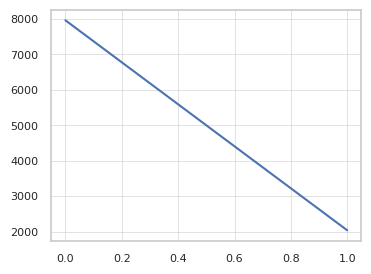

In [274]:
sns.lineplot(data=TargetValues)
plt.ylabel('');

##### 5. Data Preprocessing

Now, i'm going to manipulate the raw data into a more favorable format. First, I'll remove all unwanted entries (empty rows and duplicates).

In [275]:
df = rawData.copy()

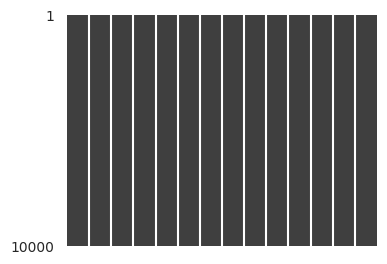

In [276]:
ms.matrix(df, fontsize=8, labels=False, sparkline=False, figsize=(4, 3));

##### 5.1 Categorical encoding
The next step is transform each categorical variable. Each label will be mapped to an integer, making it easier to use these variables in algorithms that require numerical entries.

In [277]:
textColumns = df.select_dtypes(include=['object']).columns

In [278]:
le = LabelEncoder()

for col in textColumns:
    df[col] = le.fit_transform(df[col])

##### 5.2 Correlation
The correlation matrix is ​​a table that shows how variables are related to each other, ranging from -1 to 1. This visualization is essential to identify the most important characteristics of our data.

In [279]:
CorrMatrix = df.corr()

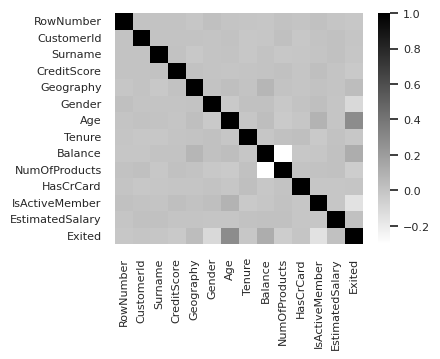

In [280]:
sns.heatmap(CorrMatrix, cmap='binary');

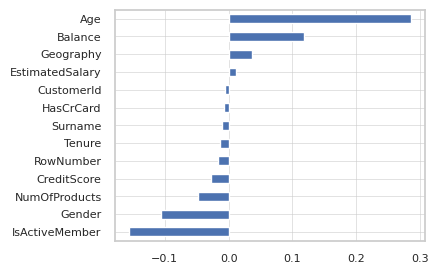

In [281]:
CorrMatrix[target].drop(target).sort_values().plot(kind = "barh");

##### 5.3 Feature engineering
Next, i will reshape our table, selecting only the variables that are most relevant to the problem. I will also remove columns that are very similar to each other to avoid a problem called [multicollinearity](https://pt.wikipedia.org/wiki/Multicolinearidade)


In [282]:
df.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender', 'Tenure', 'HasCrCard'], axis=1, inplace=True)

In [283]:
CountOfCorrelatedColumns = len(CountCorrelatedColumns(CorrMatrix))

In [284]:
print(f'\n\n Multicollinearity: {CountOfCorrelatedColumns}')



 Multicollinearity: 0


#####5.4 Outliers
Let's identify the unusual values in the data set for each column.

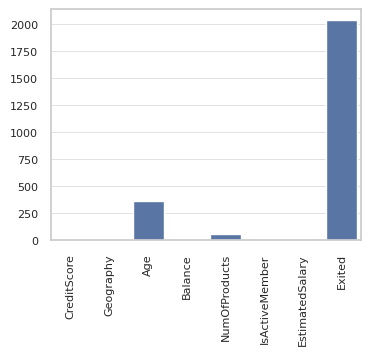

In [285]:
ShowOutliers(df)

#####5.5 Split the data into train and test sets (holdout)
In this phase, I will separate the predictor variables from the target and also split the data into training and test sets.

In [286]:
X = df.drop(target, axis=1)
y = df[target]

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2,  random_state=42)

<br>

##### 5.6 Feature scaling
Here, I'll adjust the scale of the columns to a range of 0 to 1 with `'MinMaxScaler'`.

In [288]:
scaler = MinMaxScaler()

In [289]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

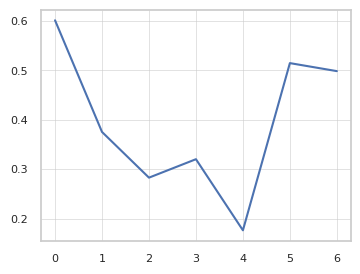

In [290]:
dfMean = pd.DataFrame(X_train).mean()
sns.lineplot(data=dfMean);

<!--
##### 5.7  Class balancing
As the classes of the target variable are unbalanced, I will increase the number of lines in the minority class with the `'oversampling'` strategy.
-->

<!--Let's remove the columns of "rownumber", "customerid", "surname" from the given dataset since they do NOT have any contribution to classification in our analysis


Outliers: Identificados nas colunas **'Credit Score'**, **'Age'**,
**'NumOfProducts'** e **'Exited'**, mas como não são falhas na entrada dos dados (visto no EDA), não os removi.

It can be concluded that there has been weak correlations between the numerical features and the target variable. So, evenif we accept the level of 0.80 as criteria for multicollinearity, it can be concluded that there is no multi-colliniearity problem among the variables". On the other hand it can be safely assumed that while our target variable of 'exited' demonstrates a slight negative correlation with the variables of "creditscore", "tenure", "numberofproducts" 'hascrcard' and 'isactivemember', it demonstrates slight positive correlation with the variables of 'age', 'balance' and 'estimatedsalary"-->

##### 5.7 Class weight
The target variable is unbalanced, so instead of using under- or over-sampling methods, i'm going to assign different weights to the classes, giving more importance to the customers who are going to leave.


In [356]:
ClassWeight = {0: 0.4, 1: 2.4}

<br>

##### 6. Hyperparameter tuning
Selecting the ideal hyperparameters for a machine learning model. Its objective is to improve performance. Used before Cross Validation

In [292]:
ModelsBasic= {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight=ClassWeight, max_depth=5, bootstrap=False),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight=ClassWeight, max_depth=5)
}

In [293]:
RfModel = ModelsBasic['RandomForest']
RfRandomSearch = FindBestParameters(RfModel, {}, X_train, y_train)

In [294]:
DtModel = ModelsBasic['DecisionTree']
DtRandomSearch = FindBestParameters(DtModel, {}, X_train, y_train)

<br>

##### 6.1 Cross validation
Training the models and comparing their performances (accuracy) with cross validation in order to choose one of them for hyperparameter tuning.

In [295]:
ModelsTunned = {
    'RandomForestTunned': RfRandomSearch.best_estimator_,
    'DecisionTreeTunned': DtRandomSearch.best_estimator_
}

In [296]:
PerfModels = CrossValidation(ModelsTunned, X_train, y_train, Metric='recall')
PerfModelSorted = PerfModels.sort_values(by='recall')

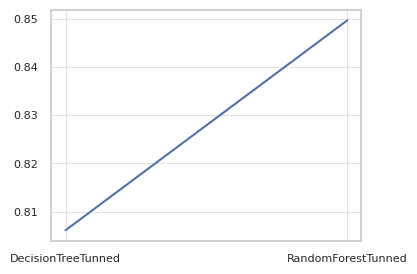

In [297]:
sns.lineplot(x='Model', y='recall', data=PerfModelSorted)
plt.xlabel('')
plt.ylabel('');

##### 6.2 Overfitting
When a machine learning model fits the training data very well but has difficulty predicting unseen data, the model is memorizing and not learning the patterns.

In [357]:
FinalModelTunned = ModelsTunned['RandomForestTunned']
FinalModelTunned.fit(X_train, y_train);

In [299]:
TrainPred = FinalModelTunned.predict(X_train)
TestPred = FinalModelTunned.predict(X_test)

In [300]:
RecallTrain = recall_score(y_train, TrainPred)
RecallTest = recall_score(y_test, TestPred)

In [301]:
print('\n\n Recall/Train:' , RecallTrain)
print(' Recall/Test:', RecallTest)



 Recall/Train: 0.8699386503067484
 Recall/Test: 0.8574938574938575


##### 6.3 Cofunsion Matrix
Confusion matrix is a table used to evaluate the performance of a model, showing the count of true positives, true negatives, false positives and false negatives.

In [302]:
ConfusionMatrix = confusion_matrix(y_test, TestPred)

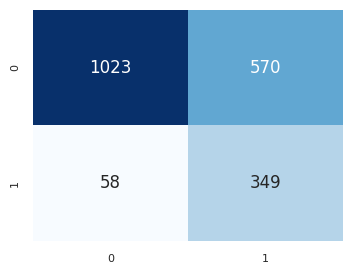

In [303]:
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues',cbar=False)
plt.show()

##### 6.4 Tradeoff recall/precision

When the probability of a prediction is greater than 0.5, the instance is classified as positive, if not, it is classified as negative.

So, if my priority is to find customers who will leave in the future, I could lower the threshold to maximize recall, even if I had to sacrifice the precision of my model.

This could be my decision, because the cost of losing a customer is much higher than the cost of retaining a customer who wasn't really thinking about canceling.

In [341]:
Proba = FinalModelTunned.predict_proba(X_test)
Precision, Recall, Threshold = precision_recall_curve(y_test, Proba[:, 1])

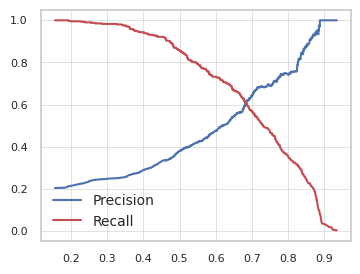

In [342]:
plt.plot(Threshold, Precision[:-1], 'b-', label='Precision')
plt.plot(Threshold, Recall[:-1], 'r-', label='Recall')
plt.legend(loc='lower left', fontsize='small', frameon=False);

##### ROC and AUC
Used to measure the performance of binary classification models, the ROC is a graphical representation of the model's performance, while the AUC quantifies it.

In [345]:
Fpr, Tpr, _ = roc_curve(y_test, Proba[:, 1])
RocAuc = roc_auc_score(y_test, Proba[:, 1])

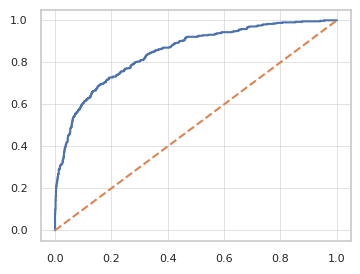

In [353]:
plt.plot(Fpr, Tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [352]:
RocAuc

0.8478578732816021

##### 6.6 Feature importances
I will look at feature importances below in order to interpret which features provide the most predictive power for the model.

In [306]:
Importance = FinalModelTunned.feature_importances_
SortedIndex = np.argsort(Importance)

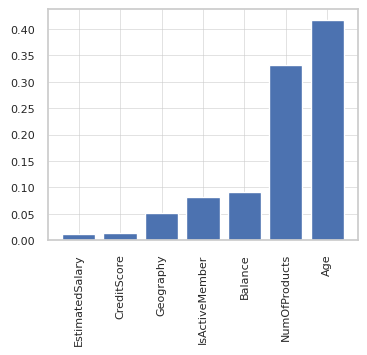

In [307]:
plt.bar(X.columns[SortedIndex], Importance[SortedIndex])
plt.xticks(rotation=90)
plt.show()